# Exercise week 10: SARSA & epsilon-greedy policy

In this exercise, you
- understand state-action values (=Q-values).
- implement the epsilon-greedy policy.
- train an agent using the SARSA algorithm.


Note: SARSA can be implemented in a few lines of code. Here, we add a lot of additional code to monitor the agent's learning. Also, we've added comments that refere
to the pseudo-code on the slides. We hope this is useful.

### Comparing state-values V with state-action-values Q  

V-values cannot be used for control! When deciding between alternative actions, we would need to know the Reward $R_{t+1}$ and the state Value $V(S_{t+1})$:

        # look ahead to calculate the expected future reward:
        next_state_a0 = T[current_state][0]
        expectedReturn_a0 = rewards[next_state_a0] + V[next_state_a0]

        next_state_a1 = T[current_state][1]
        expectedReturn_a1 = rewards[next_state_a1] + V[next_state_a1]


But the agent cannot look into the future! It does not know the reward r and the next state S' until it has taken the action a and then *observed* the outcome (next reward R, and next State S')  

A Q-value $Q(s,a)$ does not have this problem because Q-values *are* an estimate of the expected Return G for each action available in the *current* state. This estimate is learned from experience (over many episodes). In the current state s, the agent can directly compare the "goodness" of the available actions by comparing the the Q-values:

        expectedReturn_a0 = Q[current_state][0] 
        expectedReturn_a1 = Q[current_state][1] 

Once the Q-values are learned (converged), the agent has solved the task and can a greedy policy (picking the action with the max Q-value at each state) will maximize the total reward. 

The code below implements SARSA. An agent using this algorithm is at the same time i) updating (learning) the Q-values from the observations, and ii) using these Q-values to guide behaviour. It starts with some random (or zero) initialization of the Q-table. The $\epsilon$-greedy policy guarantees that the agent will keep exploring (and learning).



To illustrate the different concepts, we implement the **Agent** and the **Environment** in two different classes. This makes clear that the agent has no access to T and R, and that it has no other option than to explore the environment. 

We then implement three different agents: 
* The first agent implements a random policy. It does not learn anything (in particular, no Q-values). It only illustrates how the agent interacts with the environment.

* The second agent implements *SARSA* to learn Q-values, and the $\epsilon$-greedy policy to pick actions given the Q-values.

* The third agent is the same as the second one, but it reduces the exploration parameter $\epsilon$. By **slowly** reducing the exploration-rage $\epsilon$, two things will happen simultaneously:  
  - The agent becomes more and more greedy and the policy converges to the optimal policy $\pi^*$
  - The Q-values converge to $Q^{\pi^*}$



In [1]:
# imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import random

In [2]:
# Environment class:
# it encapsulates the reward function and the transition matrix.

class TreasureMapEnvironment:
    
    def __init__(self):
        self._state = 0

        # unchanged from prev. exercise.
        self._rewards = [0, -1, 0, -10, 4, 3, 7, 5]
        self._is_terminal = [False, False, False, True, False, True, True, True]
        self._T = [ 
                [1, 2],  # in state s0, taking action a0 brings us to state s1, a1 to s2
                [3,4],   # in state s1, taking action a0 brings us to state s3, a1 to s4
                [6,5],   # in state s2, taking action a0 brings us to state s6, a1 to s5
                [-1, -1], # state s3 is a terminal state. next-state is undefined (we use -1 here).
                [7, 7],   # from state s4, both actions lead to state s7
                [-1, -1], # state s5 is a terminal state
                [-1, -1], # state s6 is a terminal state
                [-1, -1]  # state s7 is a terminal state
            ]        
    def reset(self):
        self._state = 0
        return self._state
        
    def step(self, action):
        if self._is_terminal[self._state]:
            raise Exception("terminal state. Action not available")
        
        next_state = self._T[self._state][action]
        r = self._rewards[next_state]
        done = self._is_terminal[next_state]
        
        self._state = next_state
        return self._state, r, done, "no info"


In [3]:
# random agent for demo

class RandomAgent:
    def __init__(self, environment):
        self._env = environment
        
    def run(self, nr_episodes=1):
        for e in range(nr_episodes):
            # call reset before starting an episode
            current_state = self._env.reset()
            print("start episode {} in state S{}".format(e, current_state))
            done = False
            r_sum = 0
            while (not done):
                # pick an action from a random policy:
                random_action = random.randint(0,1)
                
                # select that action. The environment will return the next state and r:
                next_state, r, done, info = env.step(random_action)
                
                print("s:S{}, a:a{}, r:{}, s':S{}".format(current_state, random_action, r, next_state))
                
                current_state = next_state
                r_sum += r
                
            print("terminate episode {} in state S{}. Sum of rewards: {}".format(e, next_state, r_sum))
            print("*****")
        

In [4]:
env = TreasureMapEnvironment()
random_agent = RandomAgent(env)
random_agent.run(nr_episodes=5)

start episode 0 in state S0
s:S0, a:a0, r:-1, s':S1
s:S1, a:a0, r:-10, s':S3
terminate episode 0 in state S3. Sum of rewards: -11
*****
start episode 1 in state S0
s:S0, a:a1, r:0, s':S2
s:S2, a:a0, r:7, s':S6
terminate episode 1 in state S6. Sum of rewards: 7
*****
start episode 2 in state S0
s:S0, a:a0, r:-1, s':S1
s:S1, a:a0, r:-10, s':S3
terminate episode 2 in state S3. Sum of rewards: -11
*****
start episode 3 in state S0
s:S0, a:a0, r:-1, s':S1
s:S1, a:a1, r:4, s':S4
s:S4, a:a0, r:5, s':S7
terminate episode 3 in state S7. Sum of rewards: 8
*****
start episode 4 in state S0
s:S0, a:a0, r:-1, s':S1
s:S1, a:a0, r:-10, s':S3
terminate episode 4 in state S3. Sum of rewards: -11
*****


### Policy
A policy is a function that maps state-action-pairs to action-selection-probabilities. Usually, the symbol $\pi$ is used. The **optimal** policy (that policy that maximizes the total reward) is denoted $\pi^*$

Here we try different policies: 

1. The **random policy** does not take any information into account. The agent above did not learn anything. It explored, collected rewards, but did neither learn values nor improve behaviour. 

2. The **epsilon-greedy policy** (implemented below for the value $\epsilon=0.05$) picks a random action with probability epsilon. With probability $1-\epsilon$ it picks the best available action by comparing the respective Q-values: action = $argmax_a Q(S, a)$.  
In the figures below, you should note two things:  
i) the **behaviour can change abruptly** when the Q-value of a different action becomes the largest value.  
ii) Epsilon-greedy with a constant $\epsilon$, ist not the optimal policy $\pi^*$ and therefore the Q-values do not converge to the maximum values. Remember: The Q-values depend on the policy. A different epsilon is a different policy. To illustrate this, we run several examples with different epsilon. There are two special cases: For $\epsilon=1$ we get the the random policy (and the agent learns the Q-values for the random policy). For $\epsilon=0$ we get a greedy policy. But note: a greedy policy does not explore and therefore it does not learn/solve the task! It is greedy with respect to the initial (wrong) values.
  
3. The third example implements epsilon-greedy with a decaying exploration rate. It starts exploration with $\epsilon=1$. Over time, $\epsilon$ is **slowly** reduced to $\epsilon=0$. In other words: we try many different policies, starting with a random policy and changing it to a greedy policy. Note that the policy is kept fix for the last ~500 episodes. This gives the algorithm enough time to converge.


*Implementation note: the different policies (constant epsilon, decaying epsilon) are implemented using the same function, but with different parameter values.*

In [5]:
# calculate epsilon as a function of time t, e at time t0, and a decay rate. epsilon_min is a lower bound assuring minimal exploration.
def get_epsilon_t(t, epsilon_t0=1.0, decay_rate=1.0, epsilon_min=0):
    e_t = epsilon_t0*(decay_rate**t)
    e_t = max(e_t, epsilon_min)  ## lower bound
    return e_t


In [6]:
# example call
e = get_epsilon_t(1000, epsilon_t0=1.0, decay_rate=0.999, epsilon_min=0.001)
print(e)

# no decay for t=0
e = get_epsilon_t(0, epsilon_t0=1.0, decay_rate=0.999, epsilon_min=0.001)
print(e)

# expl t=1
e = get_epsilon_t(1, epsilon_t0=1.0, decay_rate=0.9, epsilon_min=0.001)
print(e)



# constant epsilon=0.05:
e = get_epsilon_t(123,epsilon_t0=0.05)
print(e)

# constant epsilon=1:
e = get_epsilon_t(123,epsilon_t0=1.0)

print(e)



0.36769542477096373
1.0
0.9
0.05
1.0


In [7]:
# implement the epsilon-greedy policy in a separate function.
def get_epsilon_greedy_action(epsilon, s, Qsa_table):
#     print("get_epsilon_greedy_action: epsilon={}, s:{}, Qsa_table:".format(epsilon, s))
    do_explore = random.random()<=epsilon
    if do_explore:
        random_action = random.randint(0,1)
#         print("SELECT RANDOM ACTION: {}".format(random_action))
        return random_action
    else:
        # access the Q values and then compare the two options a0 and a1:
        Q_s_a0 = Qsa_table[s][0]
        Q_s_a1 = Qsa_table[s][1]
        
        # now pick the better of the two options
        if (Q_s_a0 == Q_s_a1):  #break tie
            random_action=random.randint(0,1)
#             print("BREAK TIE. Select {}".format(random_action))
            return random_action
        elif (Q_s_a0 > Q_s_a1):
#             print("SELECT GREEDY action. 0")
            return 0  # action a0 has the better Q-value
        else:
#             print("SELECT GREEDY action. 1")
            return 1


In [8]:
# example call
selected_action = get_epsilon_greedy_action(epsilon=0.2, s=1, Qsa_table=[[0.5, -1], [2.0, 3.0]])
print(selected_action)

1


### Agent / SARSA

In [9]:
# An agent that explores and learns q-values.
# It uses SARSA and the epsilon-greedy policy.
# The hyperparameters can be passed to the constructor. All parameters have default values.

## comments with ## refer to the SARSA pseudocode shown on the lecture slides

class SarsaAgent:
    def __init__(self, environment,
                alpha = 0.05,  #Learning rate (try different values)
                gamma = 1.0,  # discount factor (Try: if you set gamma to 0, the agent becomes myopic and maximizes the immediate reward, instead of the sum of rewards.

                # Hyperparameters for epsilon geedy policy
                epsilon_0 = 1.0, # initial value
                epsilon_min = 0.01, # minimal value
                epsilon_decay_factor = 1.0, # decay at each episode. Default: no decay
                 
                do_log = False
                ):
        self._env = environment

        self.alpha = alpha
        self.gamma = gamma
        
        self.epsilon_0 = epsilon_0
        self.epsilon_min = epsilon_min
        self.epsilon_decay_factor = epsilon_decay_factor

        self.done= False        
        self.do_log = do_log

        # Initialization of Q table:
        # note: for simplicity, we do not support arbitrary environments. Instead we
        # expect the treasure-map env with 8 states and 2 actions.
        
        # Initialize the Q-values for each state-action pair. 
        # The values could be chosen arbitrarily, 0 (or some small random value) is a common choice.
        self.Q_s_a = [ [0,0],  [0,0], [0,0], [0,0], [0,0], [0,0], [0,0], [0,0]]

        # For visualization: keep track of the Q-values over time
        # indices Q[state][action][time]
        self.Q_s_a_t = [[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ]]

        # The trial-by-trial RPE, for each state-action pair
        self.RPE_s_a_t = [[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ]]

        # for each step, keep track of the time-steps (episodes) when the state is visited. 
        # This makes it easier to compare the learning-process across different states.
        self.episode_s_a_t = [[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ],[ [],[] ]]

        # Keep track of the exploration rate. Visualization is important to understand the schedule and the learning
        self.epsilon_t = []
        

        
    def run(self, nr_episodes=1):
        for e in range(nr_episodes):
            # call reset before starting an episode
            ## Initialize S. In every episode, our agent starts in state s0.
            current_state = self._env.reset()
            done = False
            r_sum_undiscounted = 0
            r_sum_discounted = 0
            discount_factor_t = 1 # future rewards are discounted
            # calculate (and monitor) epsilon for each episode
            epsilon = get_epsilon_t(e, self.epsilon_0, self.epsilon_decay_factor, self.epsilon_min)
            self.epsilon_t.append(epsilon)
            
            ##Choose (action) A from (state) S using policy derived from Q 
            current_action = get_epsilon_greedy_action(epsilon, current_state, self.Q_s_a)
            if (self.do_log):
                print("start episode {} in state S{}".format(e+1, current_state))
                print("initial action: a{}".format(current_action))
                print("*****")

            ## Repeat for each step of episode
            while (not done):

                ## Take action A, observe R and S' (=next state)
                # here, the agent actually moves to the next state. 
                # It is not looking into the future. 
                # The environment will return the next state and r:
                next_state, r, done, info = env.step(current_action)

                ## Choose (next action) A' from (next state) S' using policy derived from Q 
                # note: the naming can be confusing: S' stands for *next* state. But the agent IS now in S'
                # next_action is not taken yet. It is needed for the calculation of the RPE.
                next_action = get_epsilon_greedy_action(epsilon, next_state, self.Q_s_a)

                ## Update Q(s,a). 
                #Here we write it on several lines to show the calculation of the RPE. 
                prediction = self.Q_s_a[current_state][current_action] # this is the predicted future rewards
                target = r+self.gamma*self.Q_s_a[next_state][next_action] # this is the immediate reward plus the expected rewards from s' on
                rpe = target - prediction # the RPE is a mismatch between prediction and (observed r + next Q)
                # or in one line:
                #rpe = r+self.gamma*self.Q_s_a[next_state][next_action] - self.Q_s_a[self.current_state][current_action]

                # Q(s,a) is updated towards the target value.
                self.Q_s_a[current_state][current_action] += self.alpha * rpe 

                # monitoring
                self.Q_s_a_t[current_state][current_action].append(self.Q_s_a[current_state][current_action])
                self.RPE_s_a_t[current_state][current_action].append(rpe)
                self.episode_s_a_t[current_state][current_action].append(e)

                
                if (self.do_log):
                    # logging: print the elements in S A R S A
                    print("s:S{}, a:a{}, r:{}, s':S{}, a':a{}".format(
                        current_state, current_action, r, next_state, next_action))
                    print("prediction={:.3f}, target={:.3f}, RPE={:.3f}, Q(S{},a{}) after update={:.3f}".format(
                        prediction, target, rpe, current_state, current_action, self.Q_s_a[current_state][current_action]))
                    print("")


                # In pseudo-code the symbol <- is often used to assign a value.
                ## S <- S'
                ## A <- A'
                current_state = next_state
                current_action = next_action
                
                
                r_sum_undiscounted += r
                r_sum_discounted += discount_factor_t*r
                discount_factor_t *= self.gamma

            
            if (self.do_log):
                print("terminate episode {} in state S{}.\nSum of rewards in episode: discounted (seen from S0):{}, undiscounted:{}"
                      .format(e+1, next_state, r_sum_discounted,r_sum_undiscounted))
                print("*"*80)

        if (self.do_log):
                display(self.Q_s_a)
    

In [10]:
# simple example. Roll-out a few episodes and log the values
# default policy is epsilon=1 (= random policy)
env = TreasureMapEnvironment()
agent_0 = SarsaAgent(env, alpha=0.1, do_log=True)
agent_0.run(nr_episodes = 3)


start episode 1 in state S0
initial action: a0
*****
s:S0, a:a0, r:-1, s':S1, a':a0
prediction=0.000, target=-1.000, RPE=-1.000, Q(S0,a0) after update=-0.100

s:S1, a:a0, r:-10, s':S3, a':a0
prediction=0.000, target=-10.000, RPE=-10.000, Q(S1,a0) after update=-1.000

terminate episode 1 in state S3.
Sum of rewards in episode: discounted (seen from S0):-11.0, undiscounted:-11
********************************************************************************
start episode 2 in state S0
initial action: a1
*****
s:S0, a:a1, r:0, s':S2, a':a0
prediction=0.000, target=0.000, RPE=0.000, Q(S0,a1) after update=0.000

s:S2, a:a0, r:7, s':S6, a':a1
prediction=0.000, target=7.000, RPE=7.000, Q(S2,a0) after update=0.700

terminate episode 2 in state S6.
Sum of rewards in episode: discounted (seen from S0):7.0, undiscounted:7
********************************************************************************
start episode 3 in state S0
initial action: a1
*****
s:S0, a:a1, r:0, s':S2, a':a1
prediction=0.0

[[-0.1, 0.0],
 [-1.0, 0],
 [0.7000000000000001, 0.30000000000000004],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0]]

## Visualization

In [11]:
# a helper to visualize Q(s,a) RPE
def plt_Q_RPE(state, action, Q, RPE, timestamps):
    plt.figure(figsize=[14, 5])
    plt.plot(timestamps[state][action], Q[state][action], '.', markersize=1.7, label='Q(S{},A{})'.format(state, action))
    plt.plot(timestamps[state][action], RPE[state][action], '.', markersize=1.7, label='RPE')
    plt.title('RPE and Q at state S{} for action {}'.format(state, action))
    plt.legend(loc='best')


In [12]:
def plot_all(agent):
    display(agent.Q_s_a)
    plt.figure()
    plt.imshow(agent.Q_s_a)
    plt.colorbar()
    plt.title("Q(s,a) after learning")
    plt.figure()
    plt.plot(agent.epsilon_t)
    plt.title("exploration rate epsilon vs nr-episode")
    plt.xlabel("#episode")
    plt.ylabel("epsilon")
    for s in [0, 1, 2, 4]:
        for a in [0, 1]:
            plt_Q_RPE(s, a, agent.Q_s_a_t,  agent.RPE_s_a_t, agent.episode_s_a_t)


[[-1.4416384987584872, 5.118597911160937],
 [-9.978780108657205, 8.585240800878879],
 [6.98784473516379, 2.9938226402368247],
 [0, 0],
 [4.784204873738339, 4.800835961571162],
 [0, 0],
 [0, 0],
 [0, 0]]

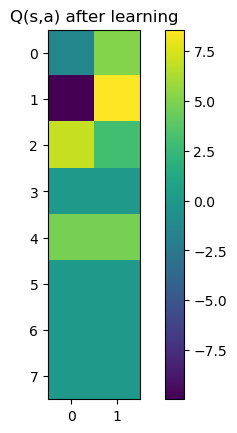

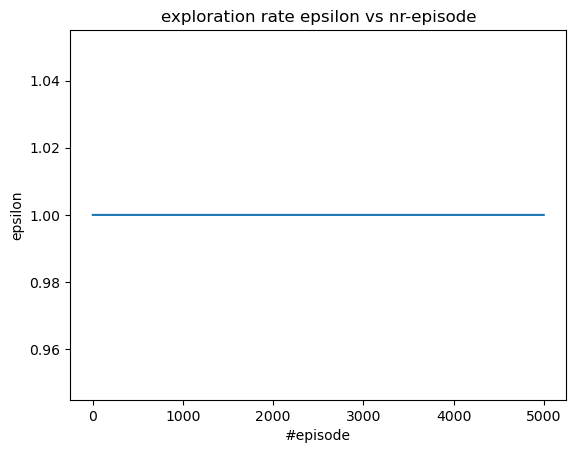

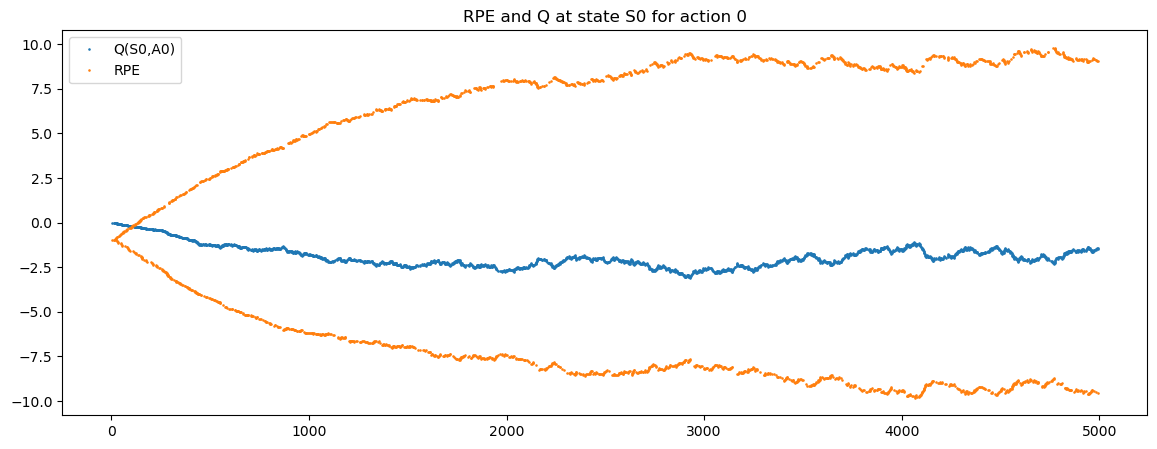

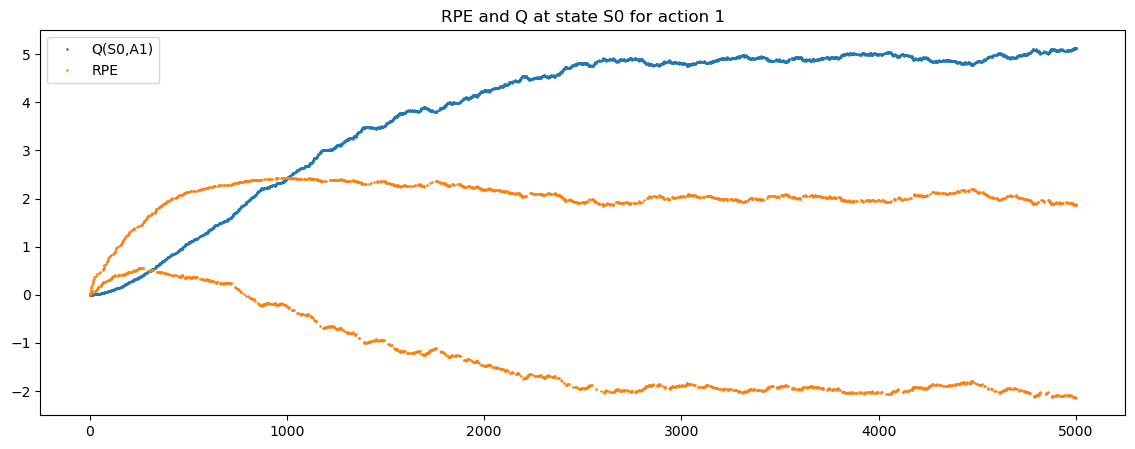

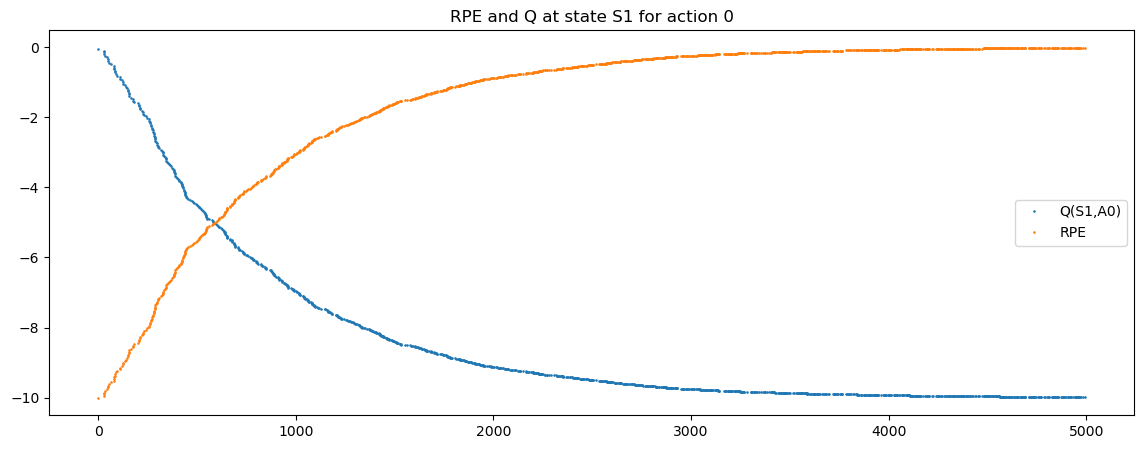

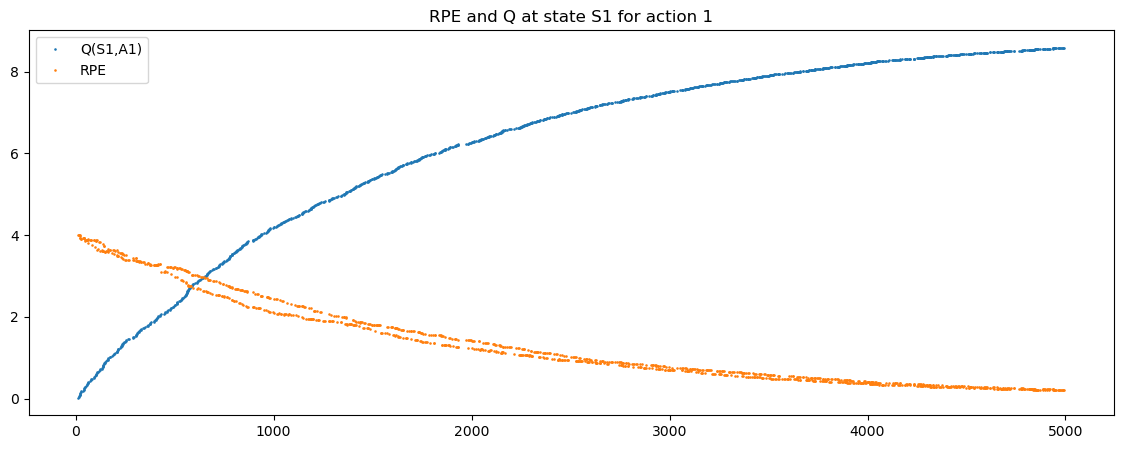

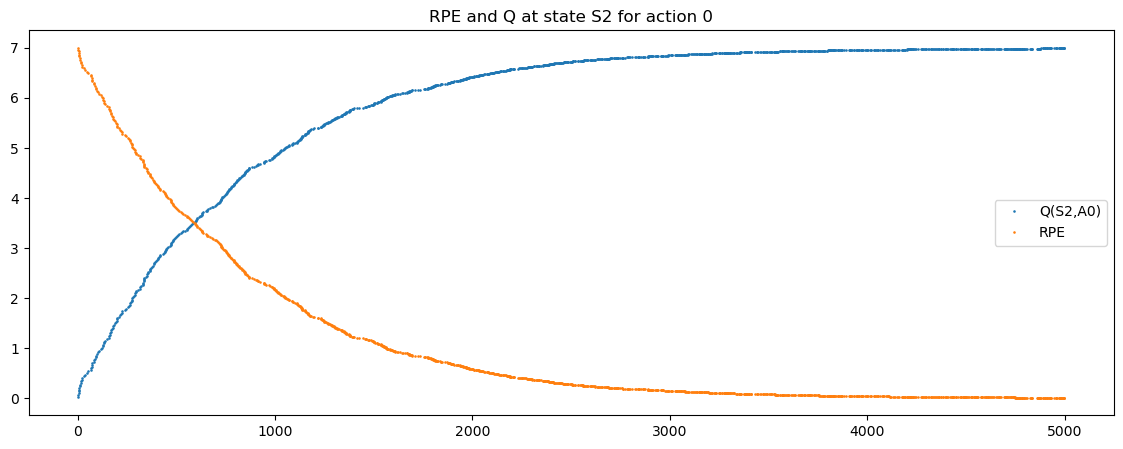

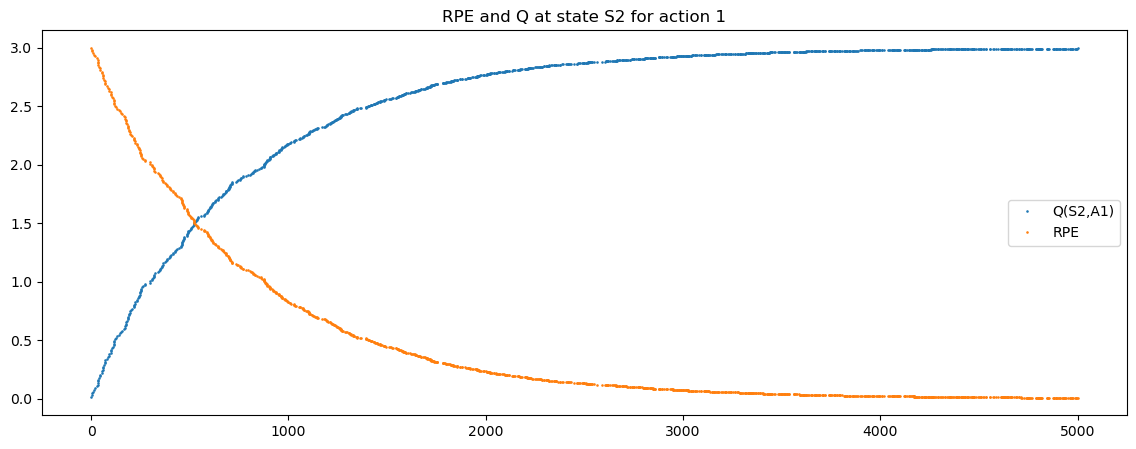

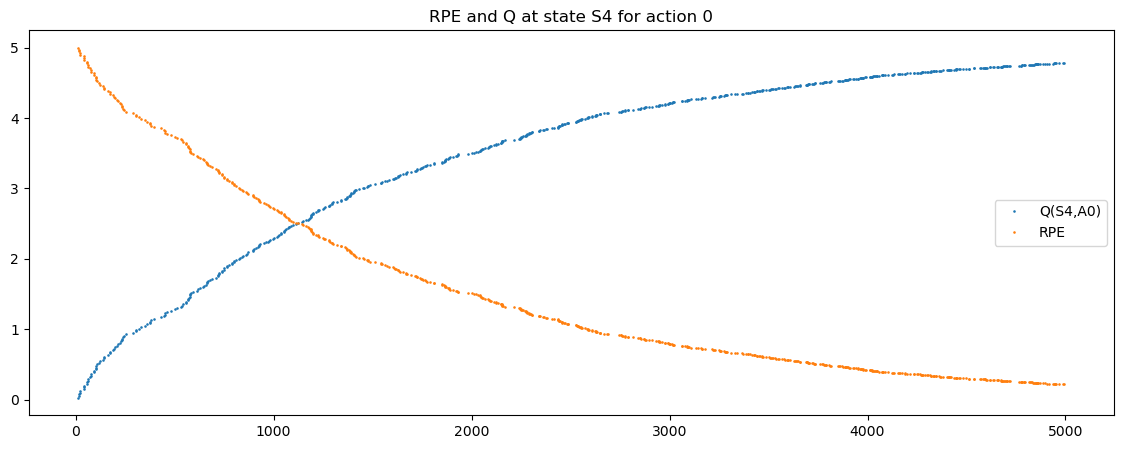

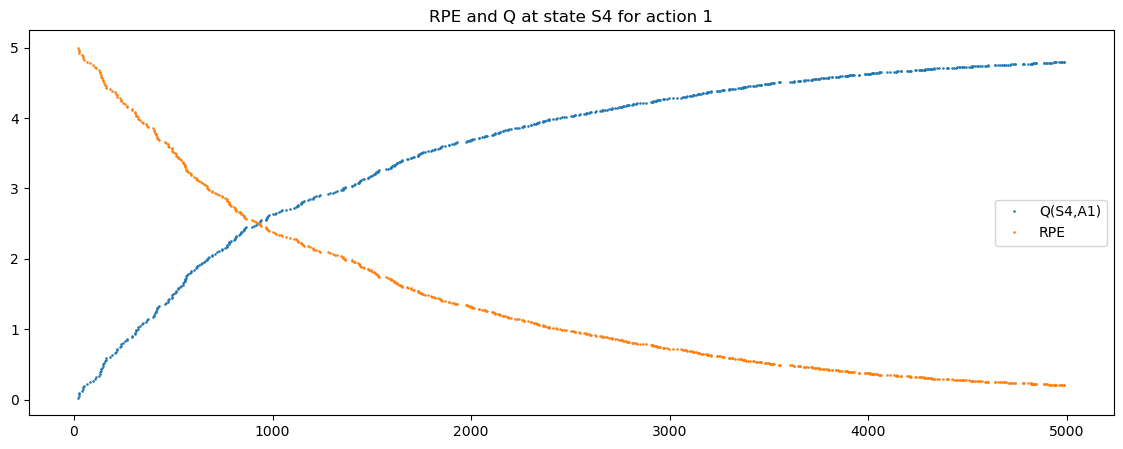

In [13]:
# keeping epsilon fixed at 0 is effectively the same as the random policy.
# we expect to reproduce the Q-values for a random behaviour.
agent_1 = SarsaAgent(env, alpha=0.005, epsilon_0 = 1, epsilon_decay_factor=1, do_log=False)
agent_1.run(nr_episodes = 5000)

plot_all(agent_1)

[[5.4588538377672435, 6.615459616920834],
 [-9.962121140776036, 8.995311648388697],
 [6.999999999999979, 2.9999999999999893],
 [0, 0],
 [4.963110191766616, 4.999999999999979],
 [0, 0],
 [0, 0],
 [0, 0]]

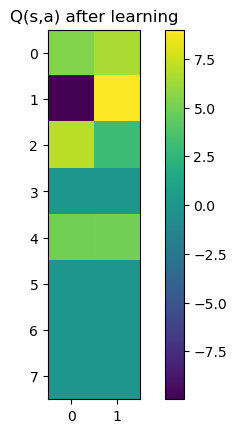

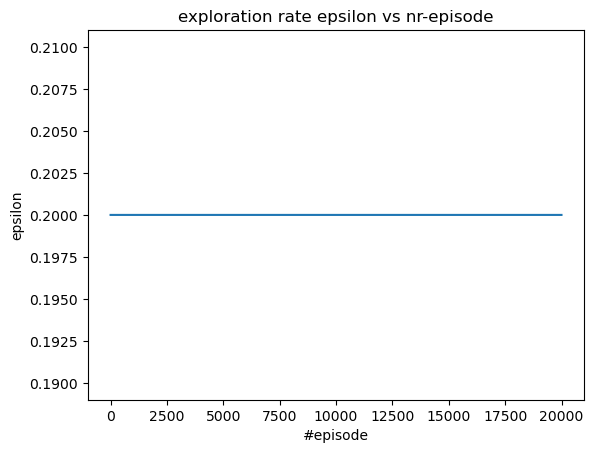

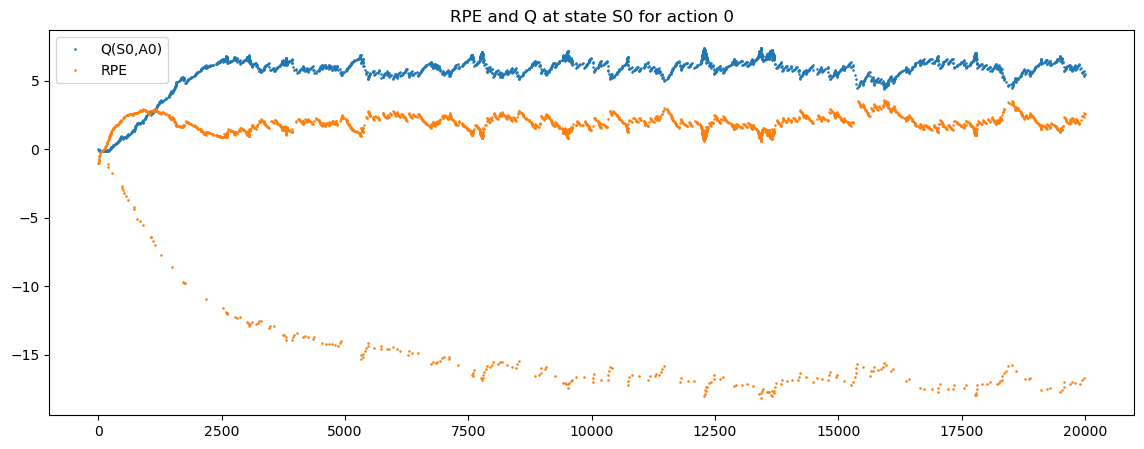

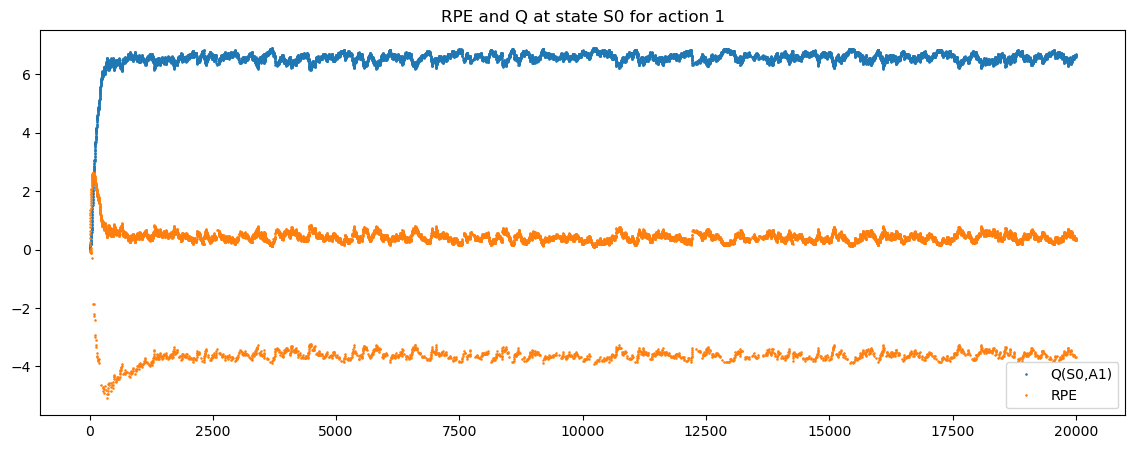

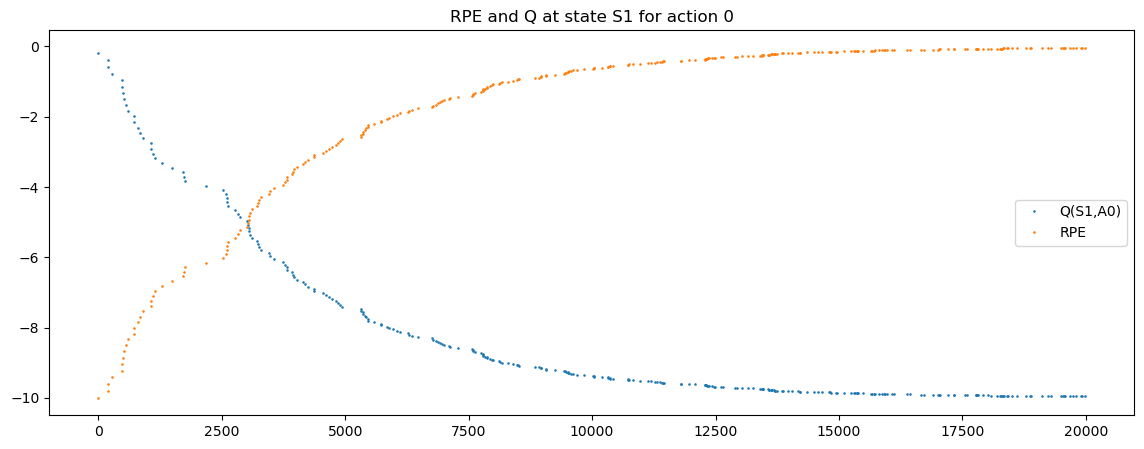

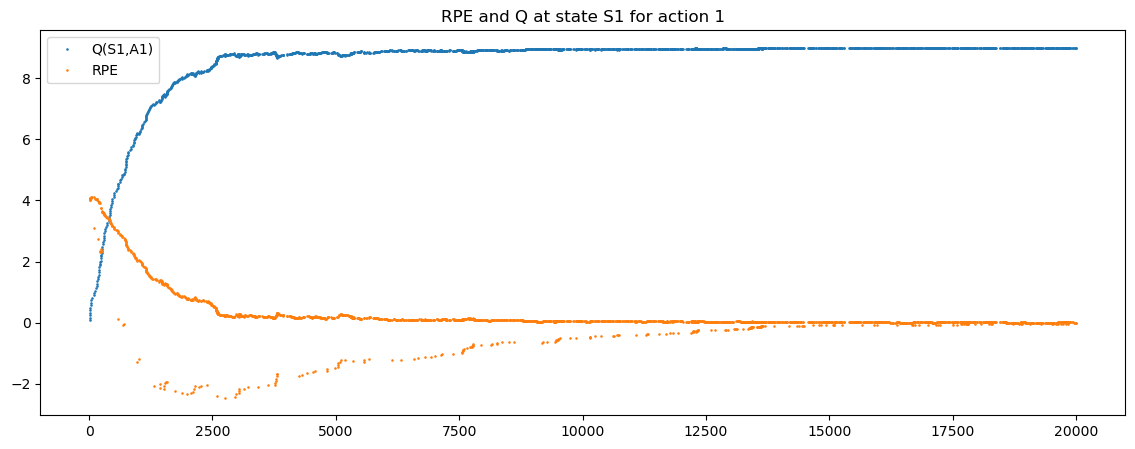

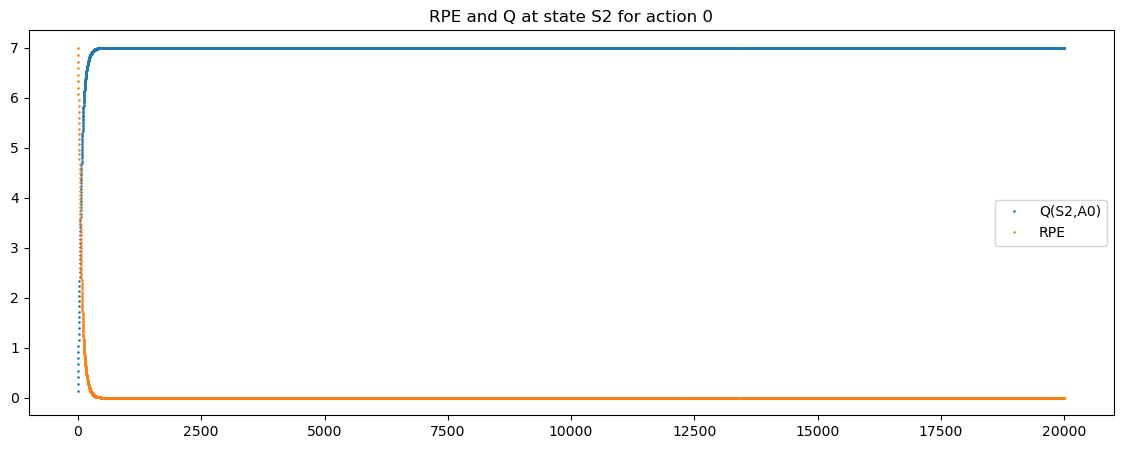

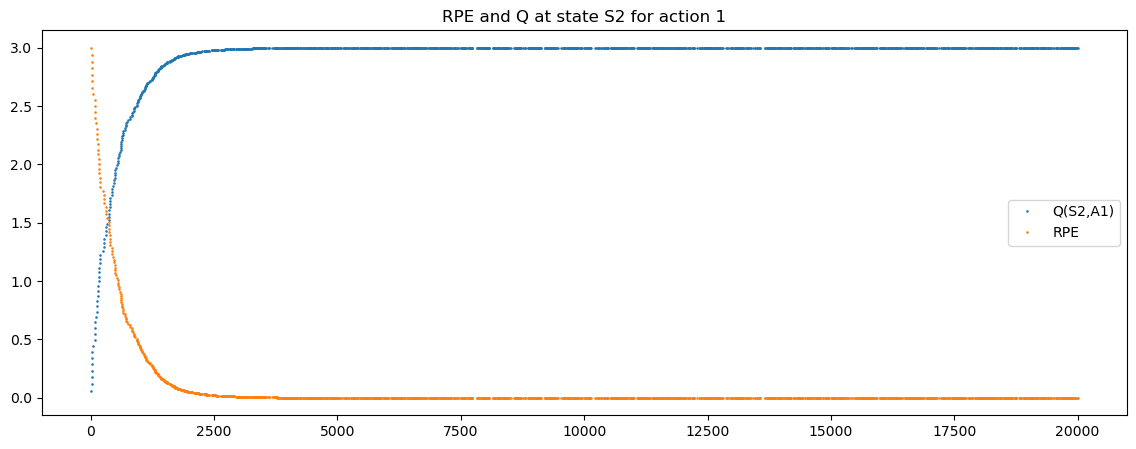

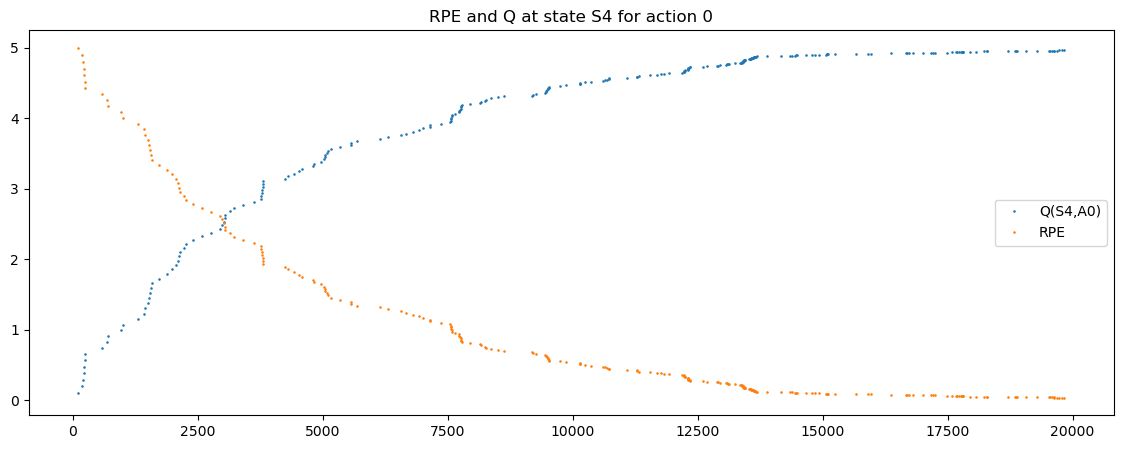

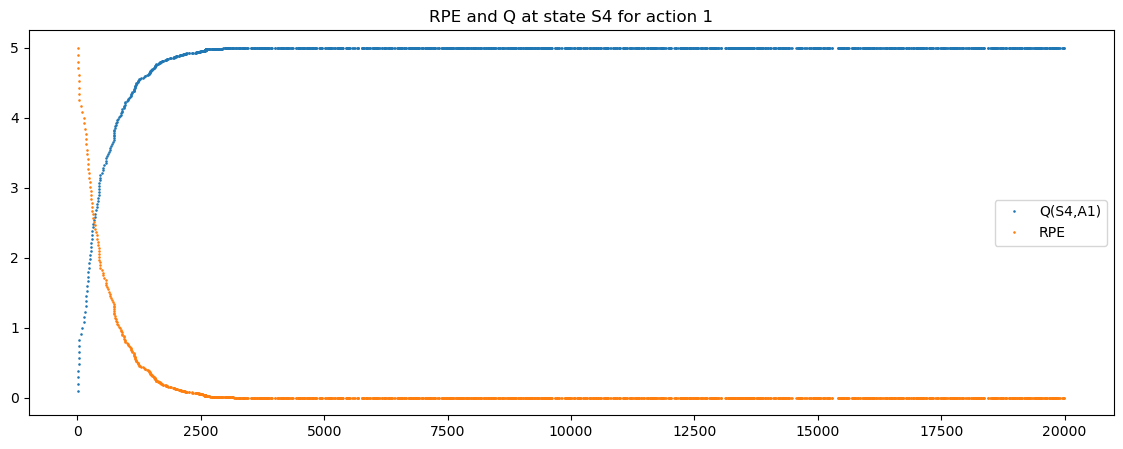

In [14]:
# keep epsilon fixed at 0.2
# not that Q(S0, A0) < Q(S0, A1) because with an exploration rate of 0.2, the agent
# keeps receiving the -10 reward at S3. That is, for a "risky" policy, going "right"
# at S0 is the safer option
agent_2 = SarsaAgent(env, alpha=0.02, epsilon_0 = 0.20, epsilon_decay_factor=1, do_log=False)
agent_2.run(nr_episodes = 20000)

plot_all(agent_2)

[[7.999999999999915, 6.865292840616297],
 [-9.976198921755593, 8.999999999999936],
 [6.999999999999979, 2.999995868194996],
 [0, 0],
 [4.93886998458568, 4.999999999999979],
 [0, 0],
 [0, 0],
 [0, 0]]

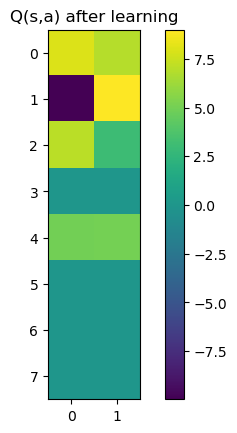

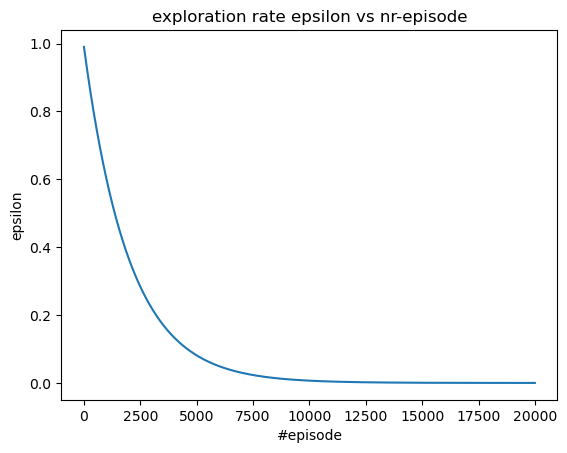

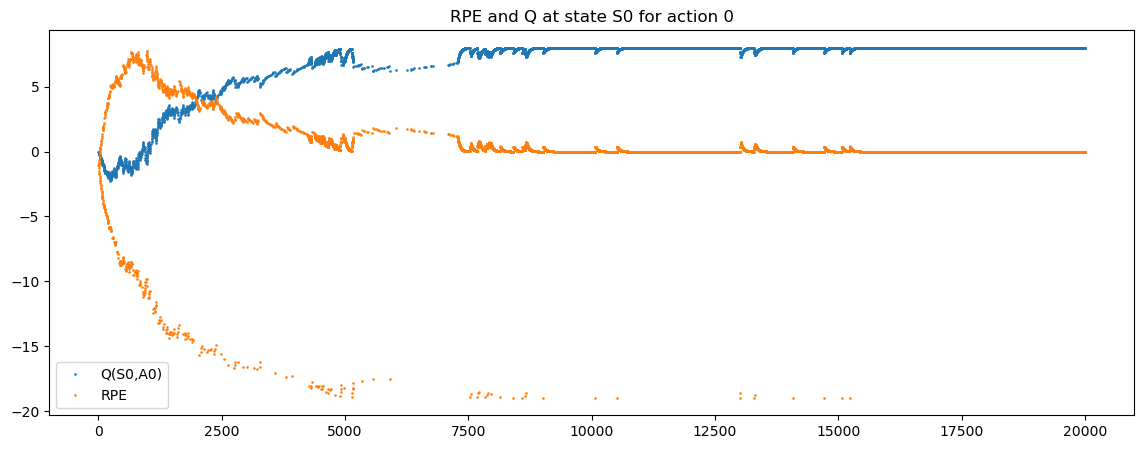

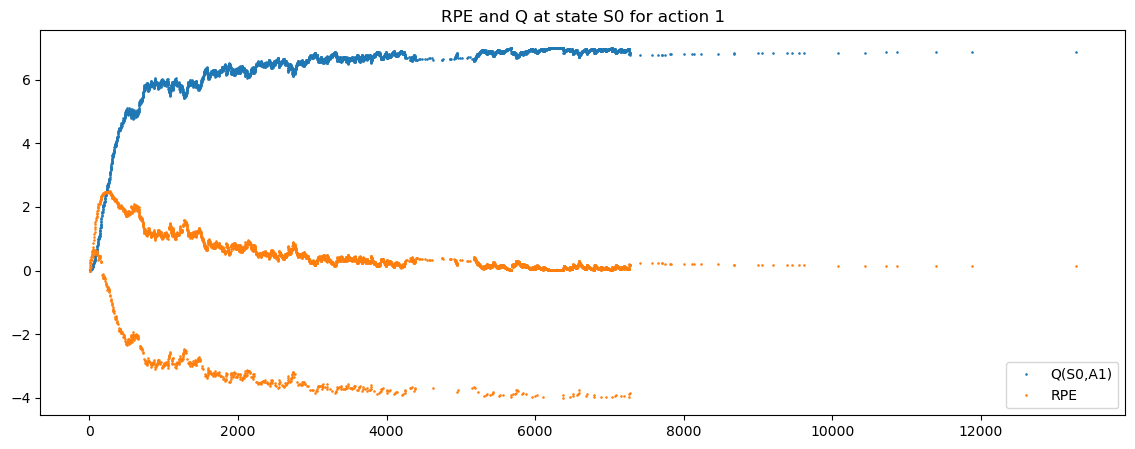

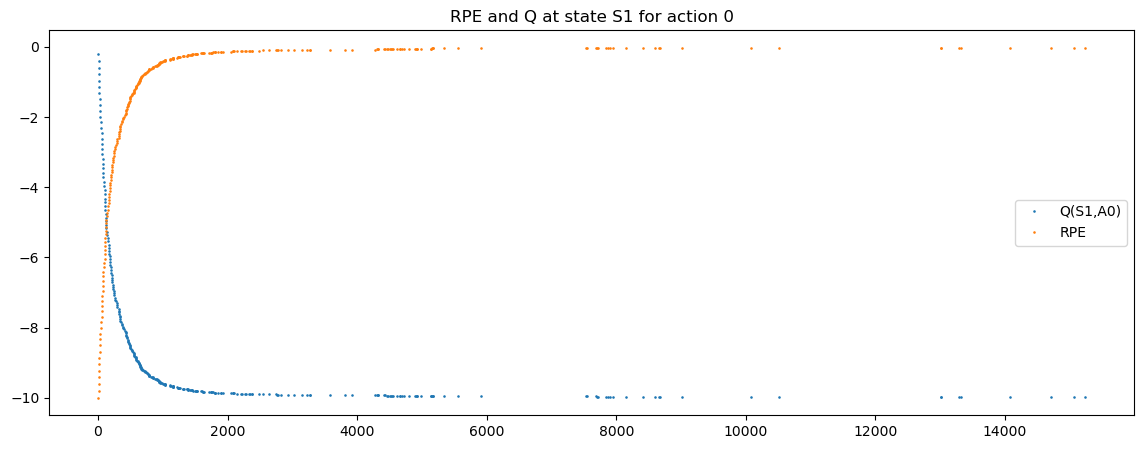

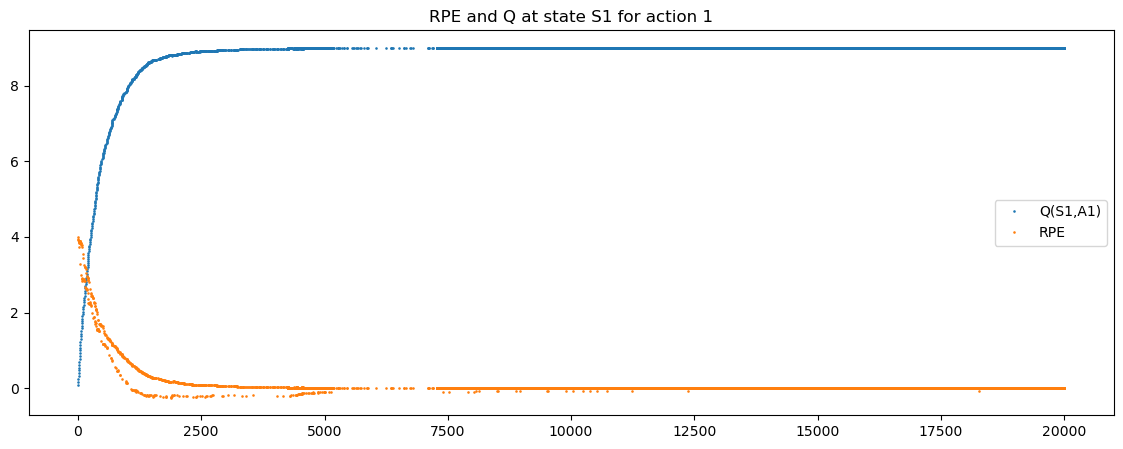

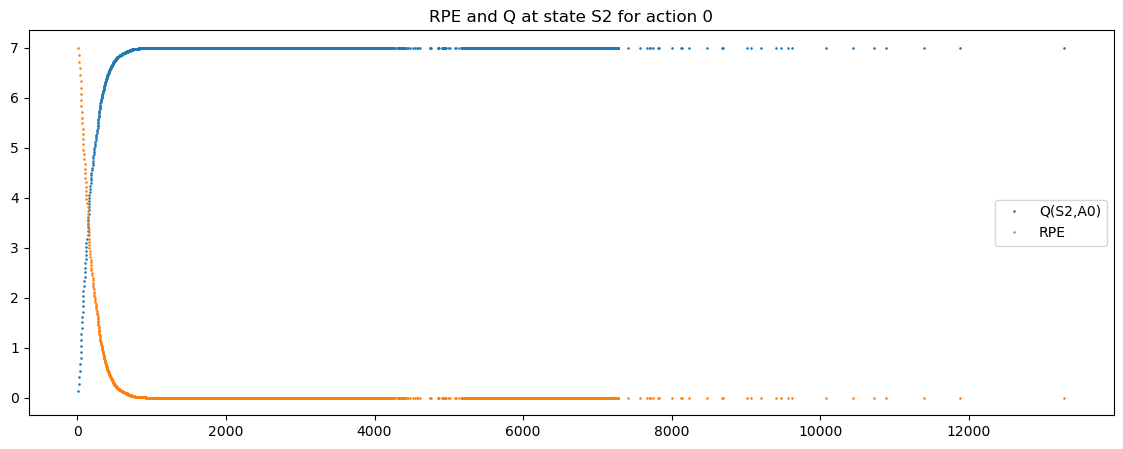

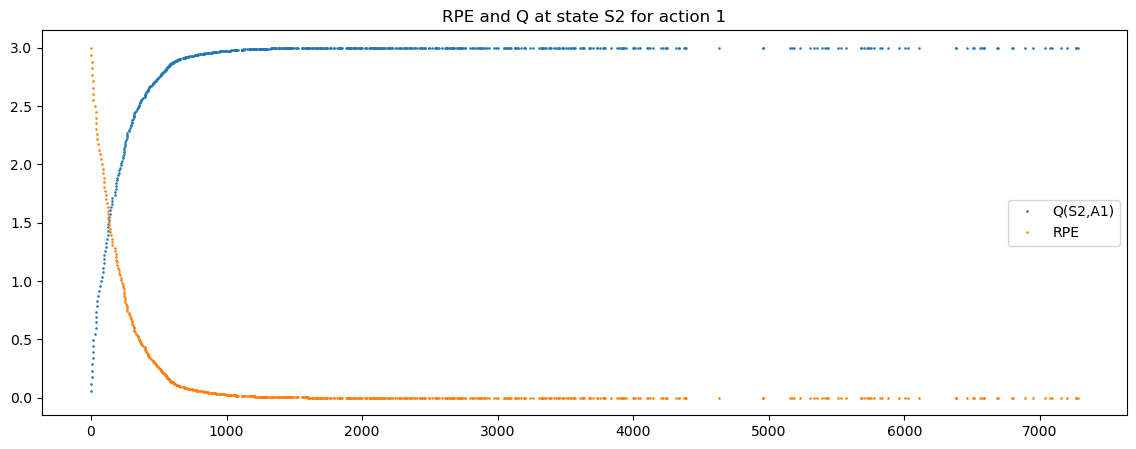

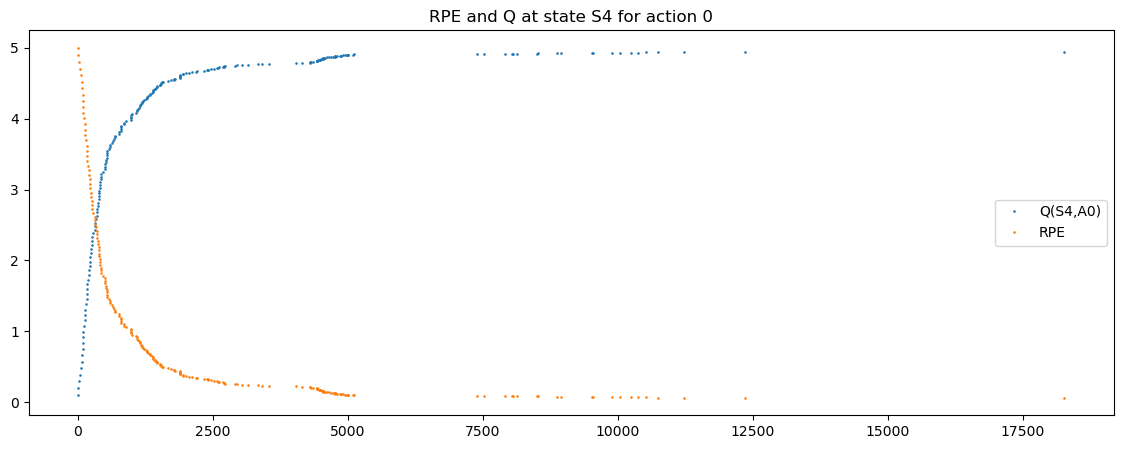

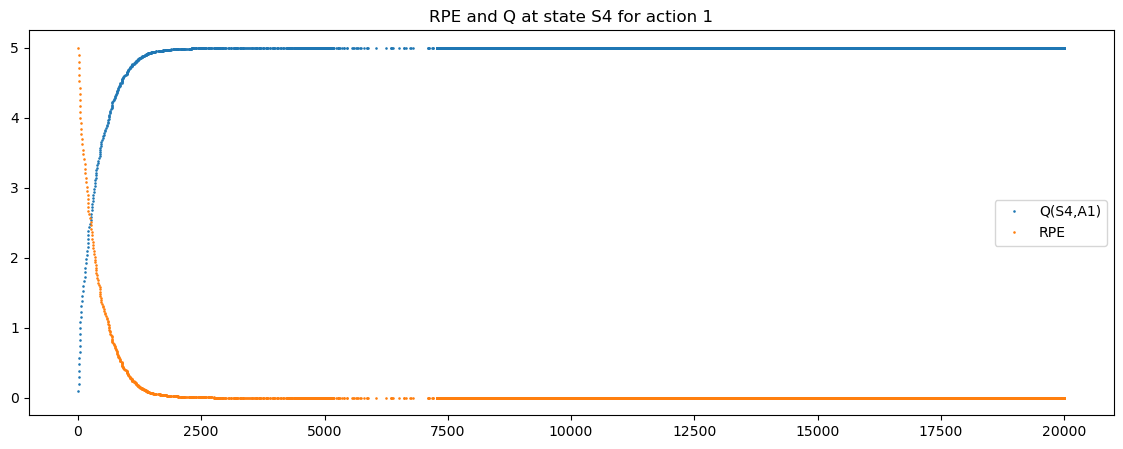

In [15]:
# This agent learns the optimal policy pi* and Q*.
agent_3 = SarsaAgent(env, alpha=0.02, 
                     epsilon_0 = 0.99, epsilon_decay_factor=0.9995,epsilon_min= 0.0,
                     do_log=False)
agent_3.run(nr_episodes = 20000)
plot_all(agent_3)


In [16]:
import numpy as np
print("Q(s,a):")
display(np.round(agent_3.Q_s_a, 2))


Q(s,a):


array([[ 8.  ,  6.87],
       [-9.98,  9.  ],
       [ 7.  ,  3.  ],
       [ 0.  ,  0.  ],
       [ 4.94,  5.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ]])

[[7.612703662786994, 6.935572501909873],
 [-9.95636707161198, 8.999845101150349],
 [6.999999999999979, 2.9999996113213614],
 [0, 0],
 [4.904658750331746, 4.999999999999979],
 [0, 0],
 [0, 0],
 [0, 0]]

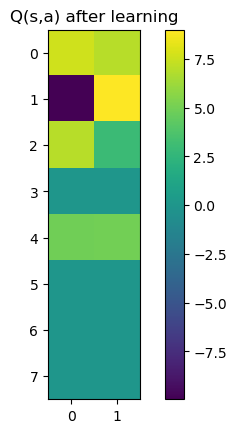

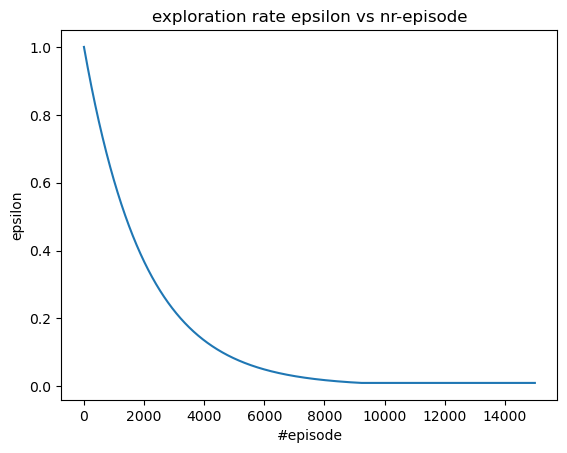

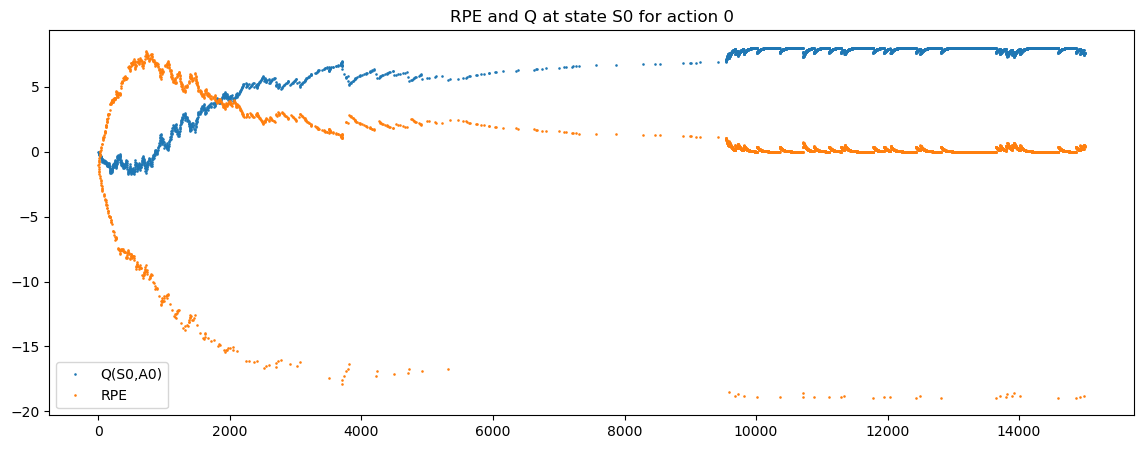

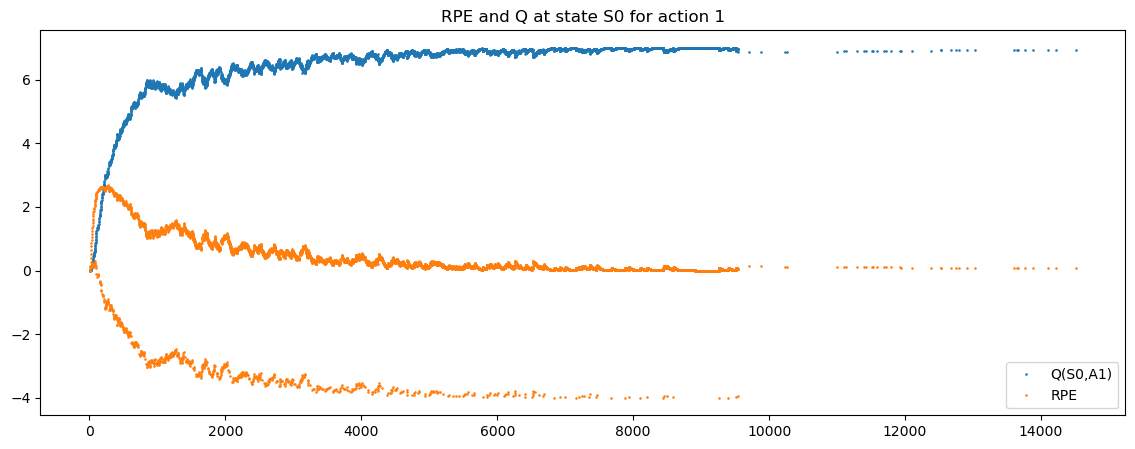

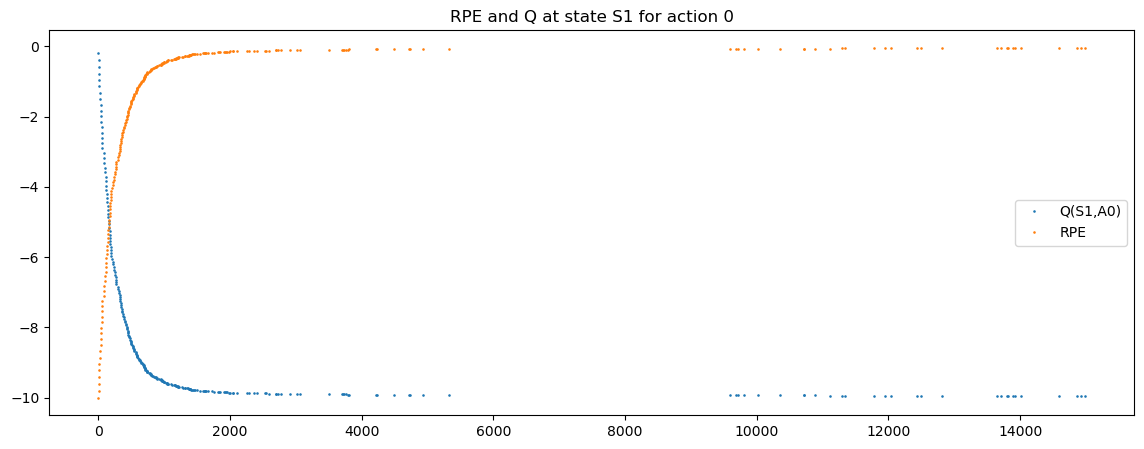

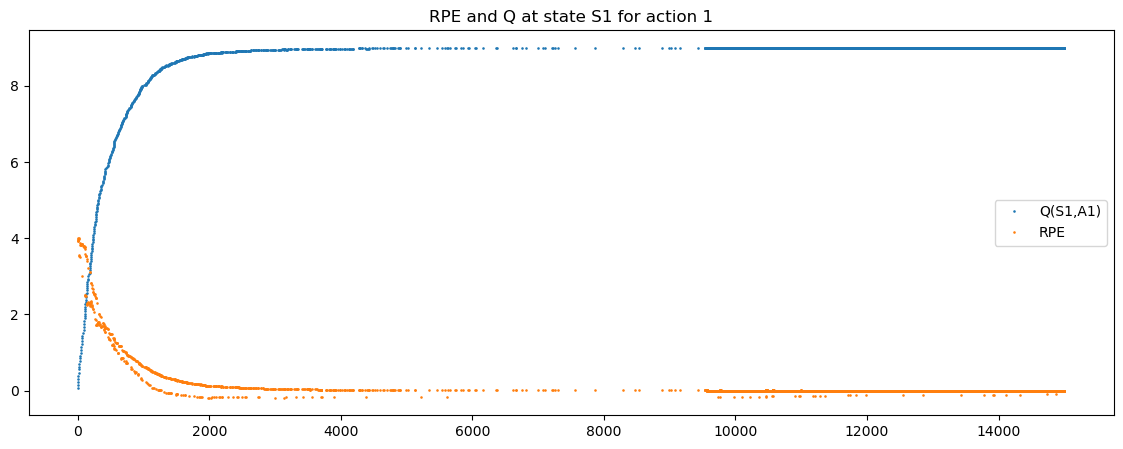

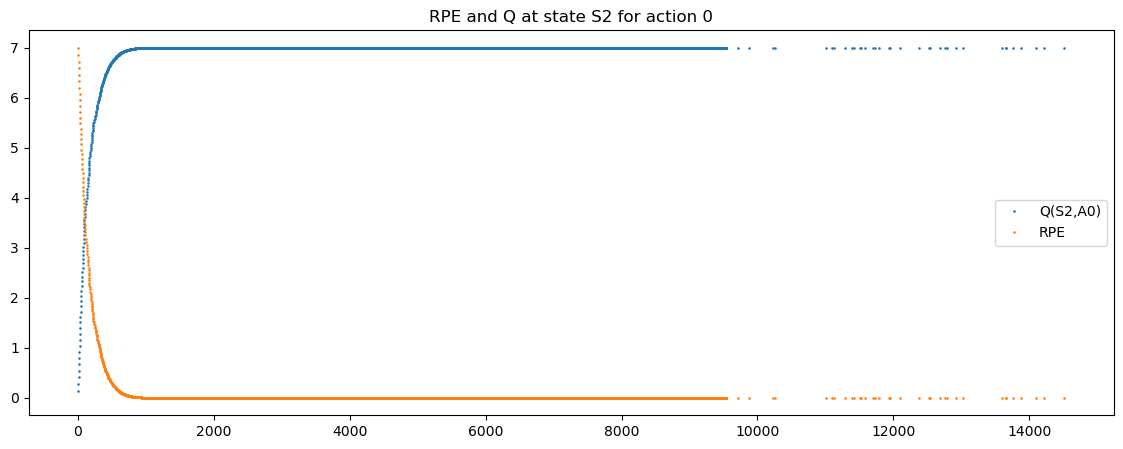

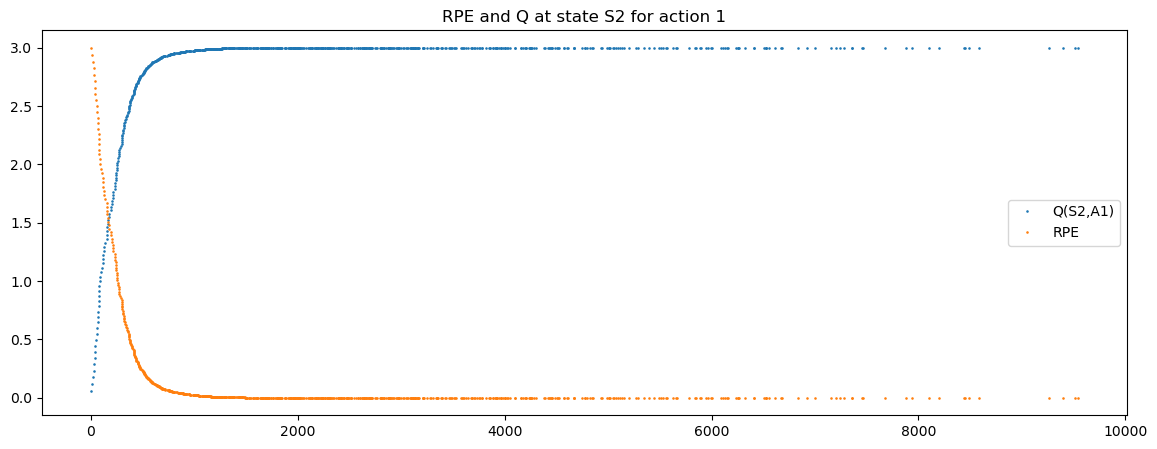

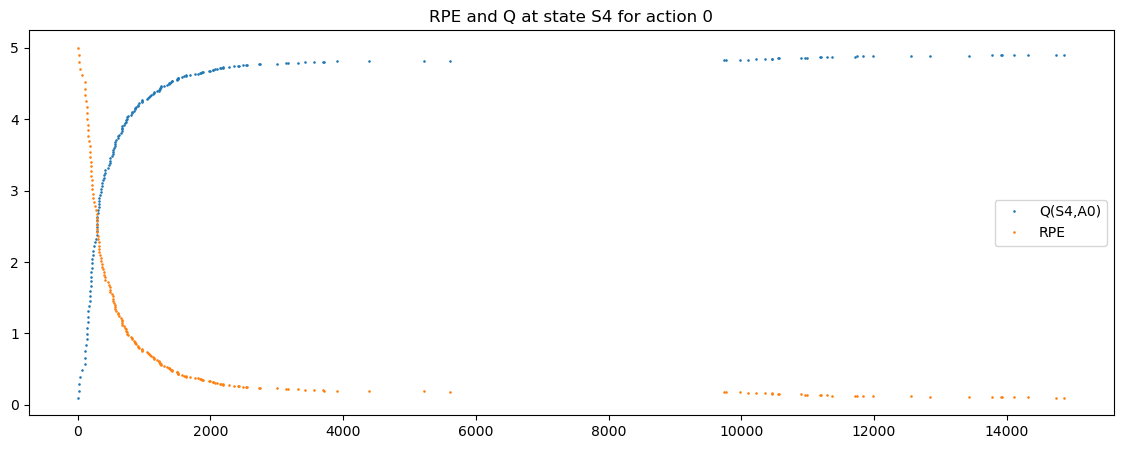

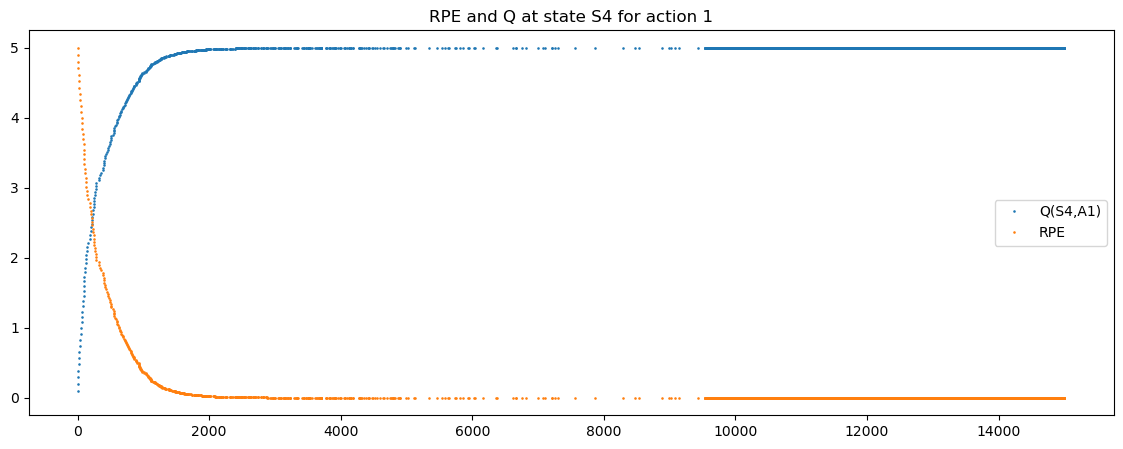

In [31]:
# epsilon decays too fast (e0*0.99^epi). After ~ 300 episode epsilon is practically 0.
# The agent becomes greedy before the q-values have converged to correct values.

agent_4 = SarsaAgent(env, alpha=0.02, 
                     epsilon_0 = 1.0, epsilon_decay_factor=0.9995,epsilon_min= 0.01,
                     do_log=False)
agent_4.run(nr_episodes = 15000)
plot_all(agent_4)



[[5.268243639806233, 5.599999999187811],
 [-9.999999878123415, 7.999999960060318],
 [6.999999999999979, 2.9999999999999893],
 [0, 0],
 [4.999992226222382, 4.999999999999979],
 [0, 0],
 [0, 0],
 [0, 0]]

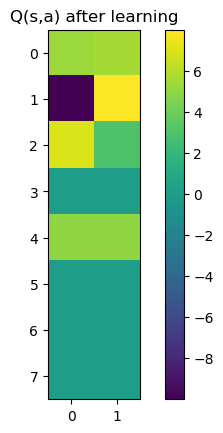

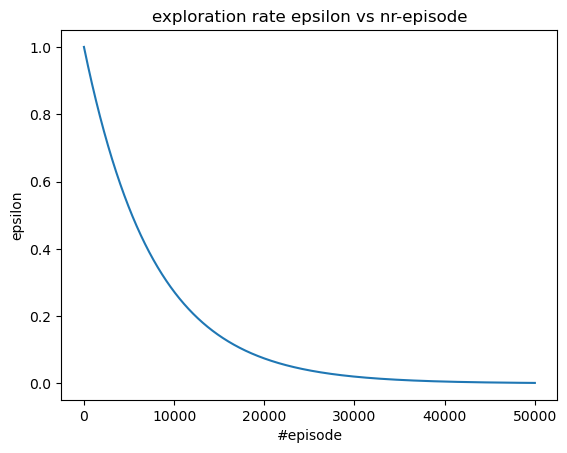

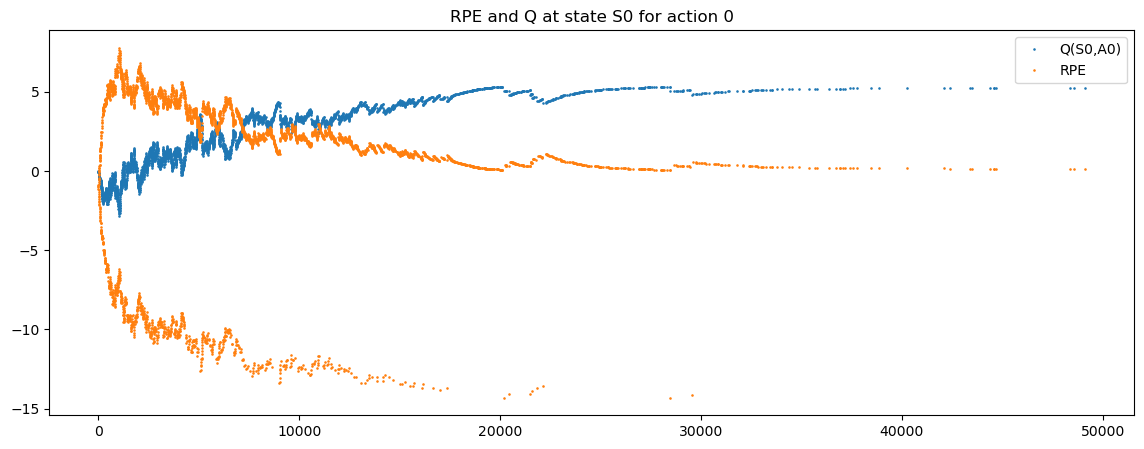

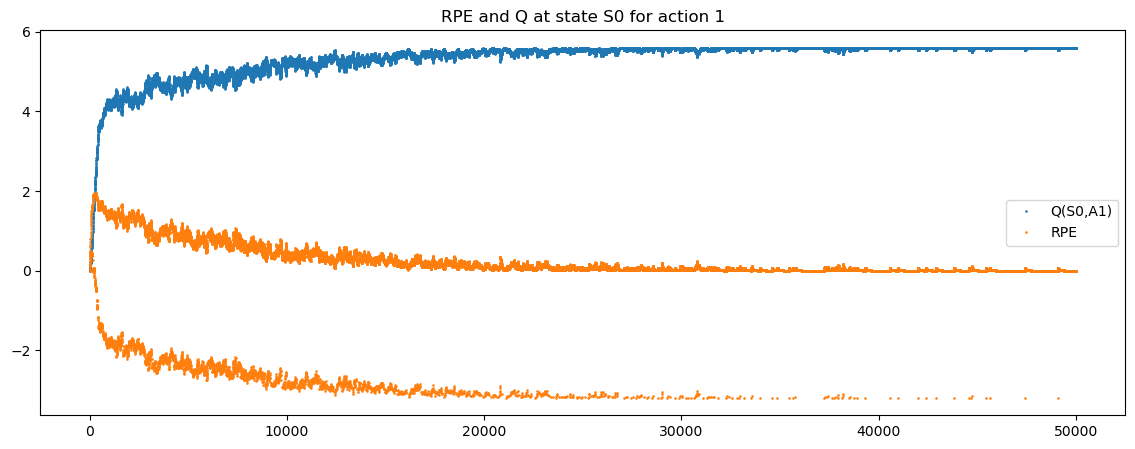

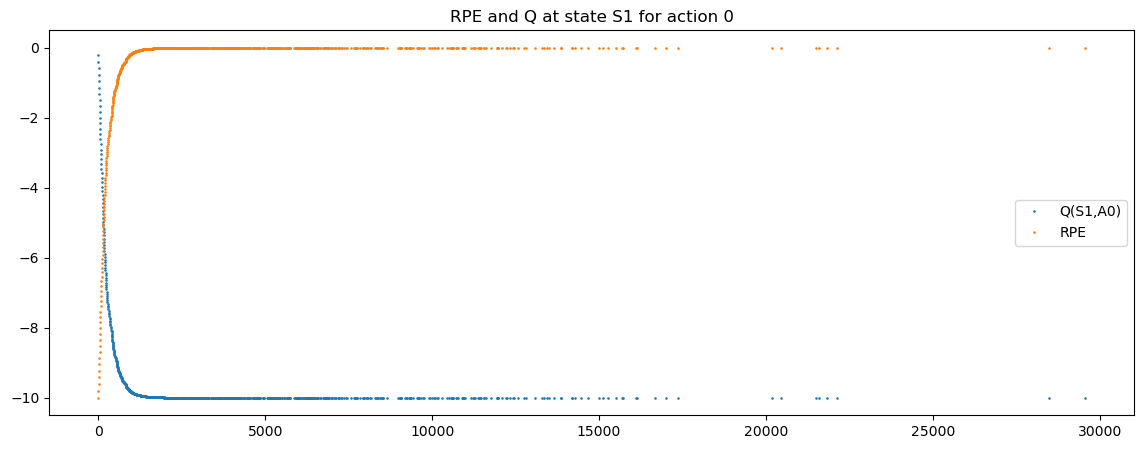

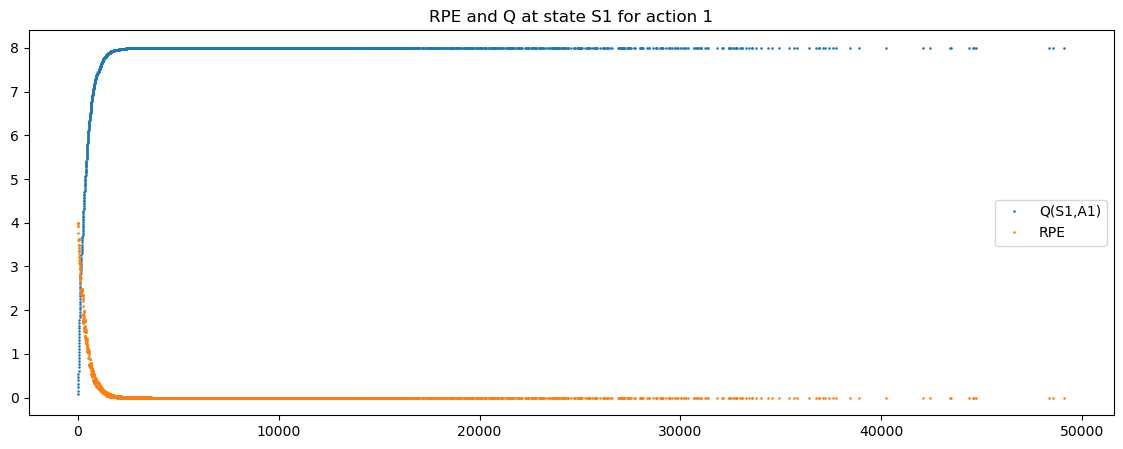

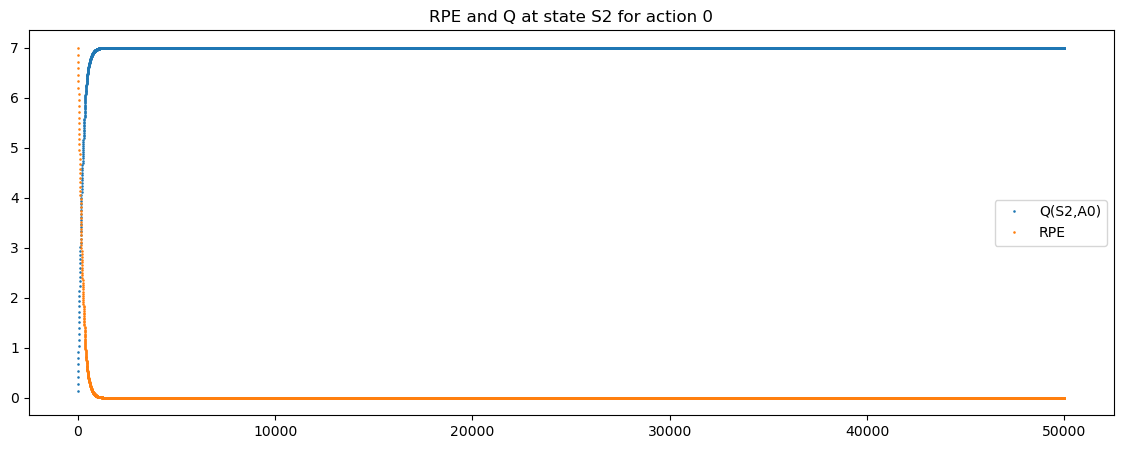

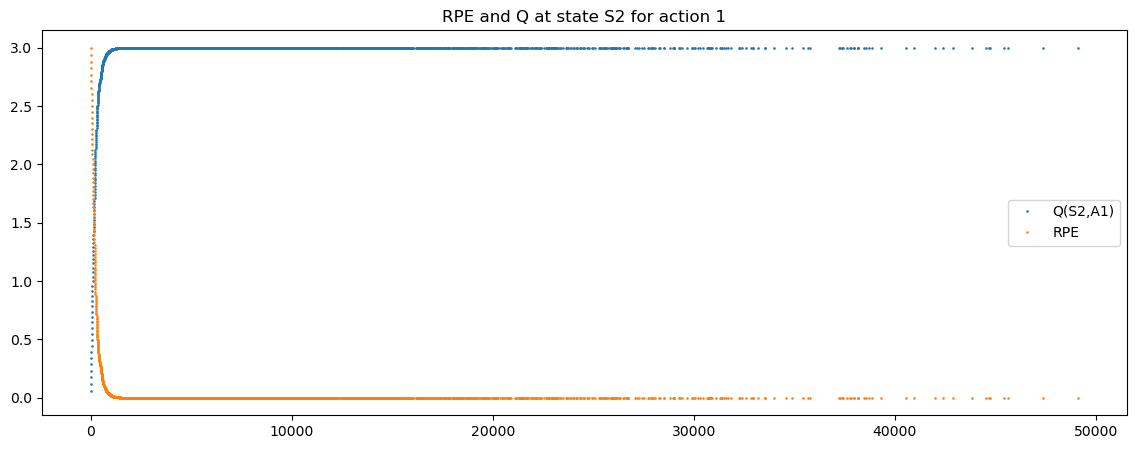

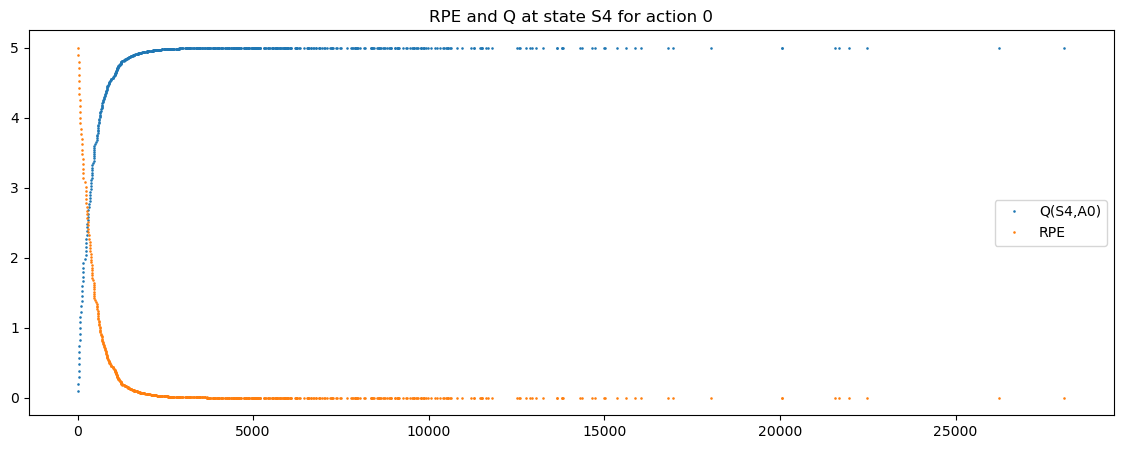

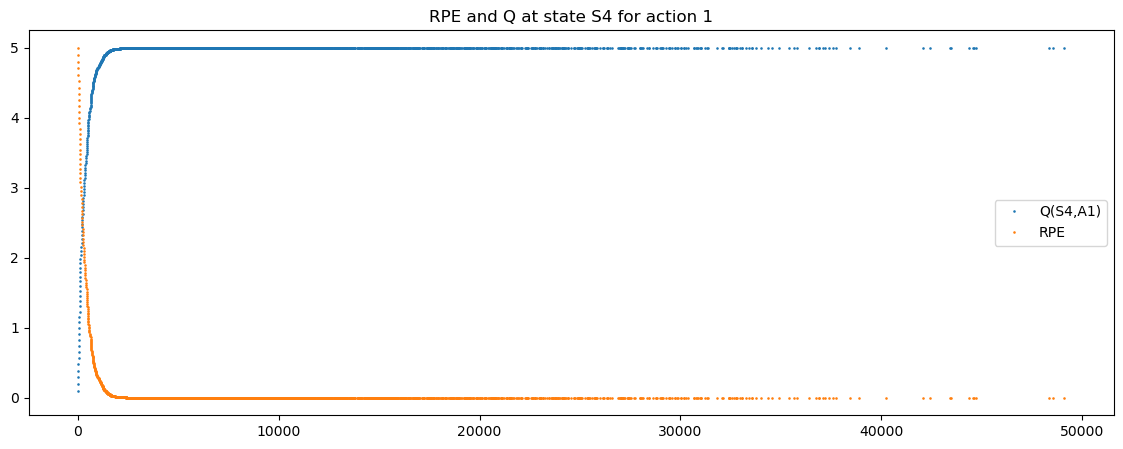

In [21]:
# same as agent_3 but with a discount factor gamma=0.8 
# note that Q(S0, A0) < Q(S0,A1) ! The +5 in S7 is devaluated: 0.8^2 * 5
# The best path starting with Q(S0, A0) has a discounted value of:
# 0.8^0 * -1  + 0.8^1 * 4  + 0.8^2 * 5 = 5.4
# The best path starting with Q(S0, A1) has a discounted value of:
# 0.8^0 * 0  + 0.8^1 * 7 = 5.6

# with some hyperparameter-tuning, SARSA finds values close to these theoretical Q-values:
agent_5 = SarsaAgent(env, alpha=0.02, 
                     gamma=0.8,
                     epsilon_0 = 1.0, epsilon_decay_factor=0.99987,epsilon_min= 0.001,
                     do_log=False)
agent_5.run(nr_episodes = 50000)
plot_all(agent_5)

